In [3]:
from model import *
from utils import * 
from optimizer import *
from visualize import *
from meta import *
import random
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import normalized_mutual_info_score as mis
import numpy as np

In [4]:
data_name = "MUTAG" #"Mutagenicity" #'IMDB-BINARY' 'MUTAG'

In [5]:
dataset = TUDataset(root='data/TUDataset', name=data_name)

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2


In [6]:
dataset = [data for data in dataset if data.x.shape[0] < 30]

In [7]:
max_n_nodes = get_max_n_nodes(dataset)
print(f'Max number of nodes: {max_n_nodes}')

Max number of nodes: 28


In [8]:
dataset = update_dataset(dataset, max_n_nodes, 2)

In [9]:
torch.manual_seed(12345)
random.shuffle(dataset)

train_dataset = dataset[:3*len(dataset)//4]
test_dataset = dataset[3*len(dataset)//4:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 141
Number of test graphs: 47


In [10]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Example of a graph in the dataset:


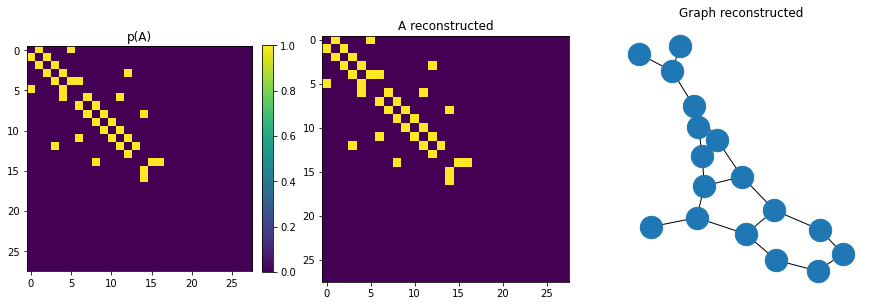

In [11]:
print('Example of a graph in the dataset:')
visualize_adj_graph(dataset[0].adj.squeeze())

## Create model

### Default VAE

In [12]:
# Base VAE class definition
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist

def get_mean_param(params):
    """Return the parameter used to show reconstructions or generations.
    For example, the mean for Normal, or probs for Bernoulli.
    For Bernoulli, skip first parameter, as that's (scalar) temperature
    """
    return params[1] if params[0].dim() == 0 else params[0]

class VAE(nn.Module):
    def __init__(self, prior_dist, posterior_dist, likelihood_dist, enc, dec, params):
        super(VAE, self).__init__()
        self.pz = prior_dist
        self.px_z = likelihood_dist
        self.qz_x = posterior_dist
        self.enc = enc
        self.dec = dec
        self.modelName = None
        self.params = params

        self._pz_mu, self._pz_logvar = self.init_pz(params)
        self.prior_variance_scale = params.prior_variance_scale
        self.gamma = nn.Parameter(torch.tensor(params.gamma), requires_grad=False)
        self.df = nn.Parameter(torch.tensor(params.df), requires_grad=False)
        print('p(z):')
        print(self.pz)
        print(self.pz_params)
        print('q(z|x):')
        print(self.qz_x)

        if self.px_z == dist.RelaxedBernoulli:
            self.px_z.log_prob = lambda self, value: \
                -F.binary_cross_entropy_with_logits(
                    self.probs if value.dim() <= self.probs.dim() else self.probs.expand_as(value),
                    value.expand(self.batch_shape) if value.dim() <= self.probs.dim() else value,
                    reduction='none'
                )

    @staticmethod
    def getDataLoaders(batch_size, shuffle=True, device="cuda"):
        raise NotImplementedError

    @property
    def device(self):
        return self._pz_mu.device

    def generate(self, N, K):
        self.eval()
        with torch.no_grad():
            mean_pz = get_mean_param(self.pz_params)
            mean = get_mean_param(self.dec(mean_pz))
            pz = self.pz(*self.pz_params)
            if self.pz == torch.distributions.studentT.StudentT:
                pz._chi2 = torch.distributions.Chi2(pz.df)  # fix from rsample
            px_z_params = self.dec(pz.sample(torch.Size([N])))
            means = get_mean_param(px_z_params)
            samples = self.px_z(*px_z_params).sample(torch.Size([K]))

        return mean, \
            means.view(-1, *means.size()[2:]), \
            samples.view(-1, *samples.size()[3:])

    def reconstruct(self, data):
        self.eval()
        with torch.no_grad():
            qz_x = self.qz_x(*self.enc(data))
            px_z_params = self.dec(qz_x.rsample())

        return get_mean_param(px_z_params)

    def forward(self, x, K=1, no_dec=False):
        qz_x = self.qz_x(*self.enc(x))
        zs = qz_x.rsample(torch.Size([K]))
        if no_dec:
            return qz_x, zs
        px_z = self.px_z(*self.dec(zs))
        return qz_x, px_z, zs

    @property
    def pz_params(self):
        mu = self._pz_mu.mul(1)
        scale = torch.sqrt(self.prior_variance_scale * self._pz_logvar.size(-1) * F.softmax(self._pz_logvar, dim=1))
        return mu, scale

    def init_pz(self, o):
        # means
        pz_mu = nn.Parameter(torch.zeros(1, o.latent_dim), requires_grad=False)

        # variances
        if o.prior_variance == 'iso':
            logvar = torch.zeros(1, o.latent_dim)
        elif o.prior_variance == 'pca':
            singular_values = self.dataset.load_pca(o.latent_dim).log()
            logvar = singular_values.expand(1, o.latent_dim)
        pz_logvar = nn.Parameter(logvar, requires_grad=o.learn_prior_variance)

        return pz_mu, pz_logvar

    def posterior_plot(self, zs_mean, zs_std, runPath, epoch):
        pass

### MUTAG VAE

In [13]:
import torch
import torch.distributions as dist
from torch.distributions.utils import broadcast_all
from numbers import Number

class Sparse(dist.Distribution):
    has_rsample = False

    @property
    def mean(self):
        return (1 - self.gamma) * self.loc

    @property
    def stddev(self):
        return self.gamma * self.alpha + (1 - self.gamma) * self.scale

    def __init__(self, gamma, loc, scale, validate_args=None):
        self.loc, self.scale = broadcast_all(loc, scale)
        self.gamma = gamma
        self.alpha = torch.tensor(0.05).to(self.loc.device)
        if isinstance(scale, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.scale.size()
        super(Sparse, self).__init__(batch_shape)

    def sample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        p = torch.bernoulli(self.gamma * torch.ones(shape).to(self.loc.device))
        res = p * self.alpha * torch.randn(shape).to(self.loc.device) + \
            (1 - p) * (self.loc + self.scale * torch.randn(shape).to(self.loc.device))
        return res

    def log_prob(self, value):
        res = torch.cat([(dist.Normal(torch.zeros_like(self.loc), self.alpha).log_prob(value) + self.gamma.log()).unsqueeze(0),
                         (dist.Normal(self.loc, self.scale).log_prob(value) + (1 - self.gamma).log()).unsqueeze(0)],
                        dim=0)
        return torch.logsumexp(res, 0)


In [14]:
# FashionMNIST model specification
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

from numpy import prod, sqrt
from torch.distributions import Laplace, Normal

class Constants(object):
    eta = 1e-6
    log2 = math.log(2)
    log2pi = math.log(2 * math.pi)
    logceilc = 88                # largest cuda v s.t. exp(v) < inf
    logfloorc = -104             # smallest cuda v s.t. exp(v) > 0
    invsqrt2pi = 1. / math.sqrt(2 * math.pi)

# Constants
dataSize = torch.Size([1, 28, 28])
imgChans = dataSize[0]
data_dim = int(prod(dataSize))

class Enc(nn.Module):
    """ https://github.com/znxlwm/pytorch-MNIST-CelebA-GAN-DCGAN/blob/master/pytorch_CelebA_DCGAN.py """
    def __init__(self, params):
        super(Enc, self).__init__()
        self.enc = nn.Linear(784, 400)
        self.c1 = nn.Linear(400, params.latent_dim)
        self.c2 = nn.Linear(400, params.latent_dim)
        # c1, c2 size: latent_dim x 1 x 1

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        e = self.enc(x.view(-1, 784))
        mu = self.c1(e)
        scale = F.softplus(self.c2(e)).view_as(mu) + Constants.eta
        return mu, scale

class Dec(nn.Module):
    """ https://github.com/znxlwm/pytorch-MNIST-CelebA-GAN-DCGAN/blob/master/pytorch_CelebA_DCGAN.py
        https://github.com/seangal/dcgan_vae_pytorch/blob/master/main.py
        https://github.com/last-one/DCGAN-Pytorch/blob/master/network.py

    """
    def __init__(self, params):
        super(Dec, self).__init__()
        self.dec = nn.Sequential(
            # input size is z_size
            nn.Linear(params.latent_dim,400),
            nn.Linear(400,784),
        )
        
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, z):
        return self.dec(z).view(-1,28,28), torch.tensor(0.1).to(z.device)  # or 0.05


class FashionMNIST(VAE):
    """ Derive a specific sub-class of a VAE for FashionMNIST. """
    def __init__(self, params):
        super(FashionMNIST, self).__init__(
            Sparse,                  # prior
            eval(params.posterior),  # posterior
            Laplace,            # likelihood
            Enc(params),
            Dec(params),
            params
        )
        self.modelName = 'fashionmnist'

    @property
    def pz_params(self):
        return self.gamma.mul(1), self._pz_mu.mul(1), \
            torch.sqrt(self.prior_variance_scale * self._pz_logvar.size(-1) * F.softmax(self._pz_logvar, dim=1))

    @staticmethod
    def getDataLoaders(batch_size, shuffle=True, device="cuda"):
        kwargs = {'num_workers': 1, 'pin_memory': True} if device == "cuda" else {}
        tx = transforms.Compose([
            transforms.Resize(size=(28, 28)),
            transforms.ToTensor(),
            transforms.Lambda(lambda p: p.clamp(Constants.eta, 1 - Constants.eta))
        ])
        train_loader = DataLoader(
            datasets.FashionMNIST('../data/fashion_mnist', train=True, download=True, transform=tx),
            batch_size=batch_size, shuffle=shuffle, **kwargs)
        test_loader = DataLoader(
            datasets.FashionMNIST('../data/fashion_mnist', train=False, download=True, transform=tx),
            batch_size=batch_size, shuffle=shuffle, **kwargs)
        return train_loader, test_loader

    def generate(self, runPath, epoch):
        N, K = 64, 9
        _, means, samples = super(FashionMNIST, self).generate(N, K)
        save_image(means.data.cpu(), '{}/gen_means_{:03d}.png'.format(runPath, epoch))
        # wrangle things so they come out tiled
        samples = samples.view(K, N, *samples.size()[1:]).transpose(0, 1)
        s = [make_grid(t, nrow=int(math.sqrt(K)), padding=0) for t in samples.data.cpu()]
        save_image(torch.stack(s),
                   '{}/gen_samples_{:03d}.png'.format(runPath, epoch),
                   nrow=int(math.sqrt(N)))

    def reconstruct(self, data, runPath, epoch):
        recon = super(FashionMNIST, self).reconstruct(data[:8])
        comp = torch.cat([data[:8], recon])
        save_image(comp.data.cpu(), '{}/recon_{:03d}.png'.format(runPath, epoch))

In [15]:
class Parameters():
    def __init__(self, num_hidden_layers, hidden_dim, fBase, prior, posterior, latent_dim, gamma, df, prior_variance, prior_variance_scale, learn_prior_variance):
        self.num_hidden_layers = num_hidden_layers
        self.hidden_dim = hidden_dim
        self.fBase = fBase
        self.prior = prior
        self.posterior = posterior
        self.latent_dim = latent_dim
        self.gamma = gamma
        self.df = df
        self.prior_variance = prior_variance
        self.prior_variance_scale = prior_variance_scale
        self.learn_prior_variance = learn_prior_variance

In [16]:
class Regulariser:
    def __init__(self, f, params=None):
        self.f = f
        self.params = params
        self.samples = None
        self.name = None

    def __call__(self, i1, i2):
        raise NotImplementedError

class MMD_DIM(Regulariser):
    def __init__(self):
        super(MMD_DIM, self).__init__(imq_dim_kernel)
        self.samples = True
        self.name = 'mmd_dim'

    def __call__(self, i1, i2):
        """assumes will only be given two inputs (for now)"""
        return self.f(i1, i2)
    
def imq_dim_kernel(X, Y):
    assert X.shape == Y.shape
    batch_size, latent_dim = X.shape
    Xb = X.expand(batch_size, *X.shape)
    Yb = Y.expand(batch_size, *Y.shape)
    dists_x = (Xb - Xb.transpose(0, 1)).pow(2)
    dists_y = (Yb - Yb.transpose(0, 1)).pow(2)
    dists_c = (Xb - Yb.transpose(0, 1)).pow(2)
    stats = 0
    off_diag = 1 - torch.eye(batch_size, device=X.device)
    off_diag = off_diag.unsqueeze(-1).expand(*off_diag.shape, latent_dim)
    for scale in [.1, .2, .5, 1., 2., 5.]:
        C = 2 * scale  # 2 * latent_dim * 1.0 * scale
        res1 = C / (C + dists_x)
        res1 += C / (C + dists_y)
        res1 = off_diag * res1
        res1 = res1.sum(0).sum(0) / (batch_size - 1)
        res2 = C / (C + dists_c)
        res2 = res2.sum(0).sum(0) * 2. / (batch_size)
        stats += (res1 - res2).sum()
    return stats / batch_size

In [17]:
def log_mean_exp(value, dim=0, keepdim=False):
    return torch.logsumexp(value, dim, keepdim=keepdim) - math.log(value.size(dim))

def has_analytic_kl(type_p, type_q):
    return (type_p, type_q) in torch.distributions.kl._KL_REGISTRY

def kl_divergence(p, q, samples=None):
    if has_analytic_kl(type(p), type(q)):
        return dist.kl_divergence(p, q)
    else:
        if samples is None:
            K = 10
            samples = p.rsample(torch.Size([K])) if p.has_rsample else p.sample(torch.Size([K]))
        # ent = p.entropy().unsqueeze(0) if hasattr(p, 'entropy') else -p.log_prob(samples)
        ent = -p.log_prob(samples)
        return (-ent - q.log_prob(samples)).mean(0)

def decomp_objective(model, x, K, beta=1.0, alpha=0.0, regs=None, components=False):
    """Computes E_{p(x)}[ELBO_{\alpha,\beta}] """
    qz_x, px_z, zs = model(x, K)
    lpx_z = px_z.log_prob(x).view(px_z.batch_shape[0], -1).sum(-1)
    pz = model.pz(*model.pz_params)
    kld = kl_divergence(qz_x, pz, samples=zs).sum(-1)
    reg = (regs(pz.sample(torch.Size([x.size(0)])).view(-1, zs.size(-1)), zs.squeeze(0)) if regs.samples else regs(pz, qz_x)) \
        if regs else torch.tensor(0)
    obj = lpx_z - (beta * kld) - (alpha * reg)
    return obj.sum() if not components else (obj.sum(), lpx_z.sum(), kld.sum(), reg.sum())

def compute_microbatch_split(x, K):
    """ Checks if batch needs to be broken down further to fit in memory. """
    B = x.size(0)
    S = int(1e8 / (K * prod(x.size()[1:])))  # float heuristic for 12Gb cuda memory
    assert (S > 0), "Cannot fit individual data in memory, consider smaller K"
    return min(B, S)

def iwae_objective(model, x, K=1, **kwargs):
    """Computes an importance-weighted ELBO estimate for log p_\theta(x)
    Iterates over the batch as necessary.
    """
    S = compute_microbatch_split(x, K)
    lw = torch.cat([_iwae_objective_vec(model, _x.contiguous(), K) for _x in x.split(S)], 1)  # concat on batch
    return log_mean_exp(lw).sum()

def _iwae_objective_vec(model, x, K=1, **kwargs):
    """Helper for IWAE estimate for log p_\theta(x) -- full vectorisation."""
    qz_x, px_z, zs = model(x, K)
    lpz = model.pz(*model.pz_params).log_prob(zs).sum(-1)
    lpx_z = px_z.log_prob(x).view(px_z.batch_shape[0], -1).sum(-1)
    lqz_x = qz_x.log_prob(zs).sum(-1)
    return lpz + lpx_z - lqz_x

In [18]:
num_hidden_layers = 1
hidden_dim = 100
fBase = 28

epochs = 30
batch_size = 16

obj = 'decomp'
K = 10
beta = 1
alpha = 0
regulariser = 'mmd_dim'

beta1 = 0.9
beta2 = 0.999
lr = 1e-4

prior = 'Normal'
posterior = 'Normal' 
latent_dim = 32
gamma = 0
df = 2

prior_variance = 'iso'
prior_variance_scale = 1.
learn_prior_variance = False

no_cuda = True
seed = 0

params = Parameters(num_hidden_layers, hidden_dim, fBase, prior, posterior, latent_dim, gamma, df, prior_variance, prior_variance_scale, learn_prior_variance)

In [19]:
model = FashionMNIST(params)

p(z):
<class '__main__.Sparse'>
(tensor(0), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]))
q(z|x):
<class 'torch.distributions.normal.Normal'>


In [20]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=lr, amsgrad=True, betas=(beta1, beta2))

In [21]:
regs = MMD_DIM()

In [22]:
objective = decomp_objective

In [23]:
t_objective = iwae_objective

In [24]:
def train(epoch, beta, alpha):
    model.train()
    b_loss = 0.
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        loss = -objective(model, data.adj, K, beta=beta, alpha=alpha,
                          regs=(regs if alpha > 0 else None))
        loss.backward()
        optimizer.step()
        b_loss += loss.item()
    print('====> Epoch: {:03d} Loss: {:.1f}'.format(epoch, b_loss/ len(train_loader.dataset)))

@torch.no_grad()
def test(epoch, beta, alpha):
    model.eval()
    b_loss = 0.
    for i, data in enumerate(test_loader):
        loss = -t_objective(model, data.adj, K=K, beta=beta, alpha=alpha, regs=None)
        b_loss += loss.item()
    print('====> Test:      Loss: {:.2f}'.format(b_loss/ len(test_loader.dataset)))

In [25]:
for epoch in range(1, 100 + 1):
        train(epoch, beta, alpha)
        test(epoch, beta, alpha)

ValueError: Value is not broadcastable with batch_shape+event_shape: torch.Size([16, 28, 28]) vs torch.Size([160, 28, 28]).

In [ ]:
qz_x, px_z, zs = model(dataset[0].adj)

In [ ]:
plt.imshow(px_z.loc.squeeze(0).detach().numpy())
plt.colorbar()

In [ ]:
plt.imshow(dataset[0].adj.squeeze())

In [ ]:
from model import *
from utils import * 
from optimizer import *
from visualize import *
from meta import *
import random

In [ ]:
visualize_recon_adj(px_z.loc.squeeze(0).detach().numpy(), dataset[0].adj.squeeze(), 0.5)